In [2]:
import pandas as pd
from pathlib import Path
import sys

ROOT = Path.cwd() if (Path.cwd() / "data").exists() else Path.cwd().parent
sys.path.insert(0, str(ROOT / "src"))
from db.es_connection import ESConnection

# Charger les sentiments
sentiments_path = ROOT / "data/result/sentiments/sentiments2.csv"
df = pd.read_csv(sentiments_path)

# Connexion ES et récupération des dates par para_id
es = ESConnection()
para_ids = df["para_id"].astype(str).tolist()
date_map = es.get_dates_for_para_ids(para_ids, date_field="date_seance")

# Associer date_seance (NaN si absent)
df["date_seance"] = df["para_id"].astype(str).map(date_map)
df["date_seance"] = pd.to_datetime(df["date_seance"], errors="coerce")

# Orateur pour chaque prise de parole
orateur_map = es.get_field_for_para_ids(para_ids, "orateur_nom")
df["orateur_nom"] = df["para_id"].astype(str).map(orateur_map)

# Groupe politique depuis deputes-historique (prenom + nom -> groupe)
dep = pd.read_csv(ROOT / "data" / "deputes-historique.csv")
dep["orateur_nom_dep"] = (dep["prenom"].fillna("") + " " + dep["nom"].fillna("")).str.strip()
# Une entrée par orateur : garder la plus récente (legislatureLast max)
dep = dep.sort_values("legislatureLast", ascending=False).drop_duplicates(subset=["orateur_nom_dep"], keep="first")
nom_to_groupe = dep.set_index("orateur_nom_dep")["groupe"]
df["groupe"] = df["orateur_nom"].map(nom_to_groupe)

df

✓ Connexion établie avec Elasticsearch


,para_id,very_negative,negative,neutral,positive,very_positive,date_seance,orateur_nom,groupe
0,1399448,0.0171,0.0856,0.4431,0.3889,0.0653,2018-07-26,Elsa Faucillon,Gauche Démocrate et Républicaine
1,3414362,0.0119,0.0246,0.0800,0.2275,0.6558,2024-03-26,Guillaume Kasbarian,Ensemble pour la République
2,3573356,0.0107,0.0423,0.3672,0.5063,0.0734,2024-11-26,Laurent Jacobelli,Rassemblement National
3,1247771,0.0200,0.0712,0.3010,0.4697,0.1379,2018-04-20,Serge Letchimy,Socialistes et apparentés
4,1395141,0.0098,0.0363,0.3252,0.5347,0.0939,2018-07-25,Catherine Kamowski,La République en Marche
...,...,...,...,...,...,...,...,...,...
1423,877862,0.0305,0.1141,0.3518,0.3960,0.1075,2016-10-24,Danielle Auroi,Non inscrit
1424,2350978,0.0331,0.1396,0.3877,0.3538,0.0859,2020-12-10,Elsa Faucillon,Gauche Démocrate et Républicaine
1425,727906,0.0358,0.1368,0.3889,0.3413,0.0970,2016-02-16,Noël Mamère,Non inscrit
1426,1681791,0.0214,0.0955,0.3684,0.3906,0.1240,2019-03-29,Jean-Paul Lecoq,Gauche Démocrate et Républicaine


In [21]:
df["groupe"].unique()

array(['Gauche Démocrate et Républicaine', 'Ensemble pour la République',
       'Rassemblement National', 'Socialistes et apparentés',
       'La République en Marche', 'Les Républicains', nan,
       'La France insoumise - Nouveau Front Populaire', 'Les Démocrates',
       'La France insoumise - Nouvelle Union Populaire écologique et sociale',
       'La France insoumise', 'Écologiste et Social',
       'Libertés, Indépendants, Outre-mer et Territoires',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'Non inscrit', 'Droite Républicaine', 'Renaissance',
       'Union des droites pour la République', 'UDI et Indépendants',
       'Gauche démocrate et républicaine', 'Libertés et Territoires',
       'Socialiste', 'Socialiste, écologiste et républicain',
       'Horizons & Indépendants', 'Socialiste, républicain et citoyen',
       'Agir ensemble', 'UDR', 'Démocrate (MoDem et Indépendants)',
       'Union des démocrates et indépendants',
       'Radical, républicai

In [3]:
# Regrouper en 4–5 familles politiques (nouveau champ)
GROUPE_TO_FAMILLE = {
    "Gauche": [
        "Gauche Démocrate et Républicaine", "Gauche démocrate et républicaine",
        "Gauche démocrate et républicaine - NUPES",
        "Socialistes et apparentés", "Socialiste", "Écologiste et Social",
        "La France insoumise", "La France insoumise - Nouvelle Union Populaire écologique et sociale",
        "La France insoumise - Nouveau Front Populaire",
    ],
    "Centre": [
        "La République en Marche", "Renaissance", "Ensemble pour la République",
        "Mouvement Démocrate (MoDem) et Démocrates apparentés", "Démocrate (MoDem et Indépendants)",
        "Horizons & Indépendants", "Agir ensemble", "Les Démocrates",
        "Libertés, Indépendants, Outre-mer et Territoires", "Libertés et Territoires",
    ],
    "Droite": [
        "Les Républicains", "UDI et Indépendants", "Droite Républicaine",
        "Union des droites pour la République",
    ],
    "Extrême droite": ["Rassemblement National", "UDR"],
    "Non inscrit": ["Non inscrit"],
}
reverse_map = {g: fam for fam, groupes in GROUPE_TO_FAMILLE.items() for g in groupes}
df["groupe_politique"] = df["groupe"].map(reverse_map).fillna("Non inscrit")
df["groupe_politique"].value_counts()
COULEURS = {
    "Extrême droite": "#EAC0FF",           # bleu marine
    "Gauche": "#E63946",              # rouge
    "Centre": "#F7B538",      # beige/macron
    "Droite": "#003189",                 # bleu
    "Non inscrit": "#808080",  # gris
    # ...
}

In [4]:

df["sentiment_score"] = (
    -2 * df["very_negative"]
    -1 * df["negative"]
    +0 * df["neutral"]
    +1 * df["positive"]
    +2 * df["very_positive"]
)

In [5]:
daily = (
    df.groupby("date_seance")["sentiment_score"]
      .agg(mean="mean", std="std", count="count")
      .reset_index()
)

In [6]:
depute_historique = pd.read_csv("../data/deputes-historique.csv")

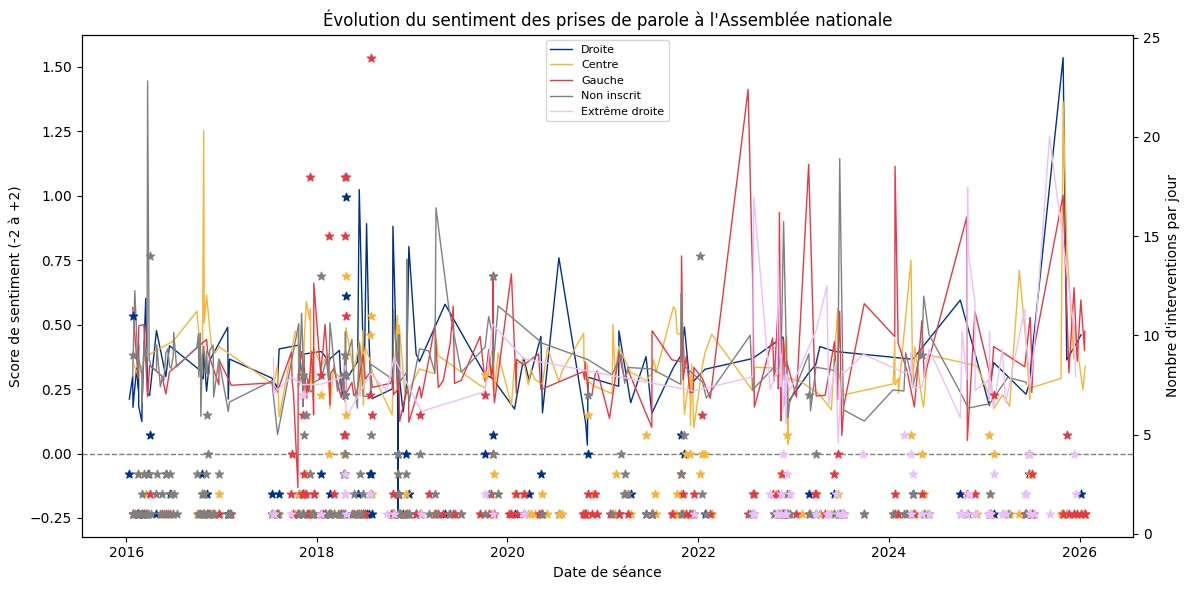

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Moyenne ET count par date et groupe politique
daily_per_group = (
    df.groupby(["date_seance", "groupe_politique"])["sentiment_score"]
    .agg(mean="mean", count="count")
    .reset_index()
)
for gp in daily_per_group["groupe_politique"].unique():
    d = daily_per_group[daily_per_group["groupe_politique"] == gp]
    line, = ax.plot(d["date_seance"], d["mean"], color=COULEURS[gp], linewidth=1, label=gp)
    ax2.scatter(d["date_seance"], d["count"], color=COULEURS[gp], marker="*") #  alpha=0.5

# ligne neutre
ax.axhline(0, linestyle="--", linewidth=1, color="gray")

ax.set_xlabel("Date de séance")
ax.set_ylabel("Score de sentiment (-2 à +2)")
ax2.set_ylabel("Nombre d'interventions par jour")
ax.set_title("Évolution du sentiment des prises de parole à l'Assemblée nationale")
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()

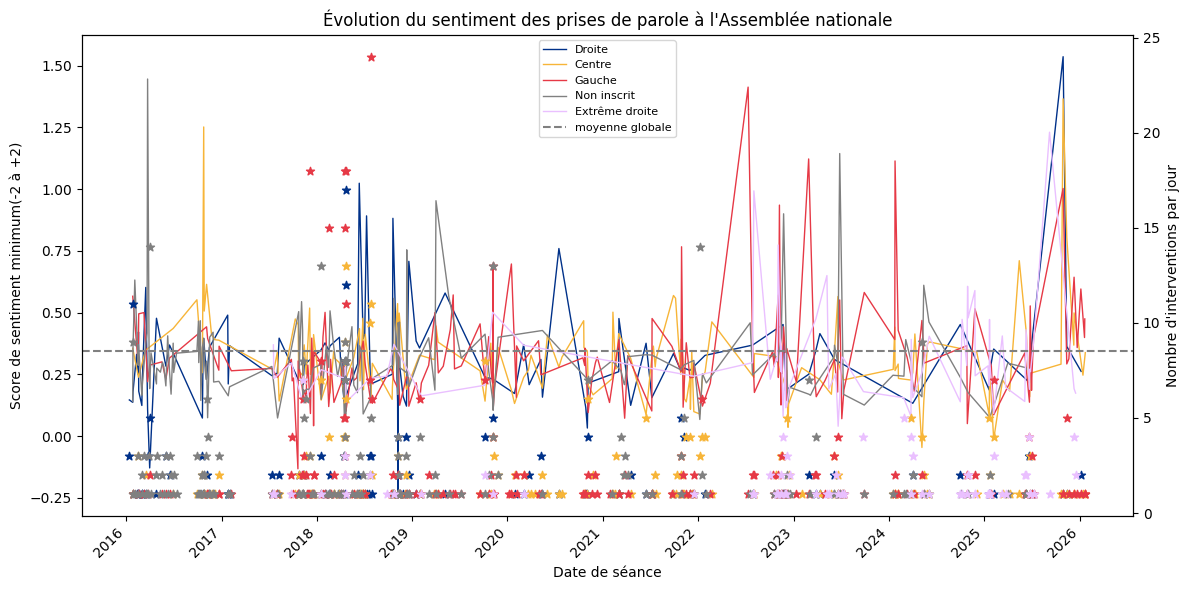

In [8]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Moyenne ET count par date et groupe politique
daily_per_group = (
    df.groupby(["date_seance", "groupe_politique"])["sentiment_score"]
    .agg(min="min",count="count")
    .reset_index()
)
for gp in daily_per_group["groupe_politique"].unique():
    d = daily_per_group[daily_per_group["groupe_politique"] == gp]
    line, = ax.plot(d["date_seance"], d["min"], color=COULEURS[gp], linewidth=1, label=gp)
    ax2.scatter(d["date_seance"], d["count"], color=COULEURS[gp], marker="*") #  alpha=0.5

# Remplacer ax.axhline(0, ...) par :
ax.axhline(df["sentiment_score"].mean(), linestyle="--", linewidth=1.5, color="gray", label="moyenne globale")


ax.set_xlabel("Date de séance")
ax.set_ylabel("Score de sentiment minimum(-2 à +2)")
ax2.set_ylabel("Nombre d'interventions par jour")
ax.set_title("Évolution du sentiment des prises de parole à l'Assemblée nationale")
ax.legend(loc="best", fontsize=8)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

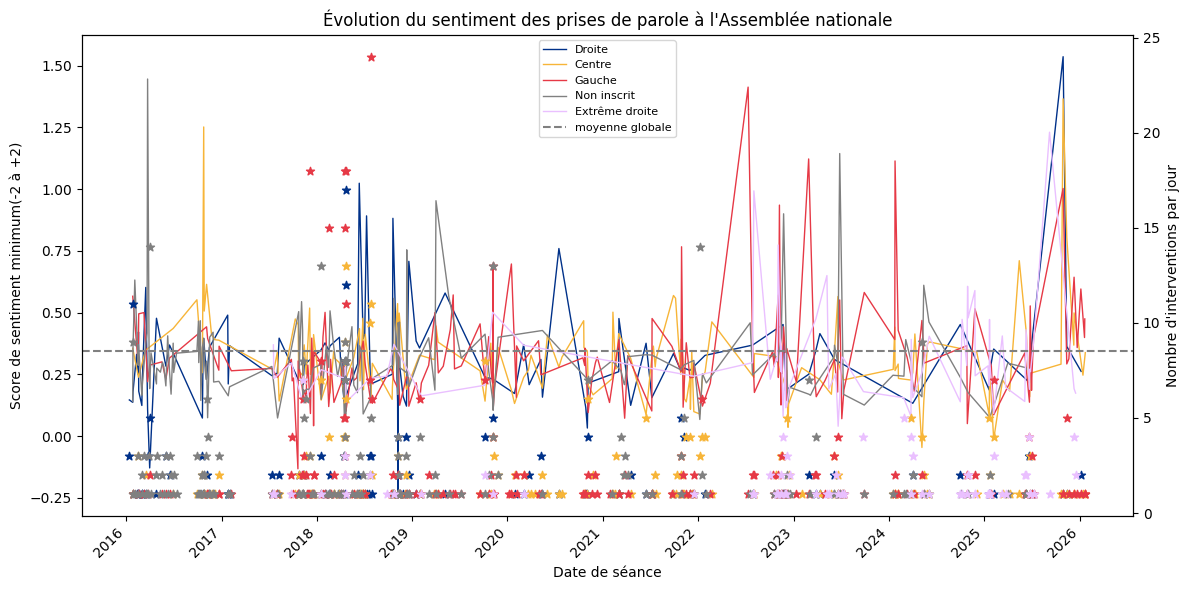

In [9]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Moyenne ET count par date et groupe politique
daily_per_group = (
    df.groupby(["date_seance", "groupe_politique"])["sentiment_score"]
    .agg(min="min",count="count")
    .reset_index()
)
for gp in daily_per_group["groupe_politique"].unique():
    d = daily_per_group[daily_per_group["groupe_politique"] == gp]
    line, = ax.plot(d["date_seance"], d["min"], color=COULEURS[gp], linewidth=1, label=gp)
    ax2.scatter(d["date_seance"], d["count"], color=COULEURS[gp], marker="*") #  alpha=0.5

# Remplacer ax.axhline(0, ...) par :
ax.axhline(df["sentiment_score"].mean(), linestyle="--", linewidth=1.5, color="gray", label="moyenne globale")


ax.set_xlabel("Date de séance")
ax.set_ylabel("Score de sentiment minimum(-2 à +2)")
ax2.set_ylabel("Nombre d'interventions par jour")
ax.set_title("Évolution du sentiment des prises de parole à l'Assemblée nationale")
ax.legend(loc="best", fontsize=8)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [7]:
# Score synthétique 0–4 (moyenne pondérée) pour une lecture plus simple
evo["score"] = sum(evo[c] * i for i, c in enumerate(cols_sentiment))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(evo["periode"], evo["score"], color="black", marker="o", markersize=4)
ax.set_xlabel("Date (mois)")
ax.set_ylabel("Score (0 = very_negative, 4 = very_positive)")
ax.set_title("Évolution du sentiment moyen (interventions « migrants »)")
ax.axhline(y=2, color="gray", linestyle="--", alpha=0.7, label="neutre")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'cols_sentiment' is not defined

In [16]:
list_id = df[df['groupe_politique'] == "Extrême droite"].sort_values('sentiment_score').head(10)['para_id'].tolist()
texte = es.get_field_for_para_ids(list_id, "texte")


In [19]:
texte

{'3167579': 'Ces 3\xa0milliards d’euros pourraient servir à la rénovation énergétique, à l’éducation ou au système de santé, notamment aux hôpitaux. Par vos amendements de suppression, vous refusez, en définitive, de donner aux douanes les moyens de lutter contre les trafiquants, qui volent à la fois l’État et les Français. Il en est de même sur l’immigration\x80: vous refusez de lutter contre les réseaux de passeurs. La politique migratoire laxiste fait rêver les migrants d’un eldorado qui n’existe pas, et ces migrants sont victimes de mafias. Certains risquent leur vie pour franchir nos frontières par les mers ou par les montagnes. Dès lors, une question se pose\x80: refusez-vous que les douanes utilisent des drones pour localiser des personnes même lorsque celles-ci mettent leur vie en danger\x80? Vous êtes les complices des passeurs, dont les migrants, comme les Français, sont les victimes\x80! Chers collègues des autres groupes, votons l’article\xa011 \xa0quater \x80! Votons en fa

In [ ]:
list_id = df[df['groupe_politique'] == "Extrême droite"].sort_values('very_negative').head(10)['para_id'].tolist()
texte = es.get_field_for_para_ids(list_id, "texte")


'…«\xa0ne pourront pas sortir du centre administratif\xa0». Pourtant, à peine deux semaines plus tard, la situation est catastrophique\x80: la quasi-totalité de ces migrants…'